In [0]:
!pip install tensorflow==2.00

     |████████████████████████████████| 86.3MB 66kB/s 
     |████████████████████████████████| 3.8MB 45.9MB/s 
     |████████████████████████████████| 450kB 43.6MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
import skimage
from skimage.color import label2rgb

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [44]:
from google.colab import files
uploaded = files.upload()

Saving all_patches.hdf5 to all_patches.hdf5


In [62]:
import h5py
with h5py.File('all_patches.hdf5', 'r') as luna_h5:
    all_slices = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('data', all_slices.shape, 'classes', all_classes.shape)

data (6691, 64, 64) classes (6691, 1)


In [50]:
ls

['ct_slices', 'slice_class']

In [0]:
from google.colab import files
uploaded = files.upload()

Saving lungnodule_dataset.csv to lungnodule_dataset.csv


In [0]:
data = pd.read_csv('lungnodule_dataset.csv')

In [63]:
from skimage.filters import laplace
all_lesion_df = pd.DataFrame(dict(les_img = [x for x in all_slices], 
                                  malignant = all_classes[:,0]))
all_lesion_df['mean'] = all_lesion_df['les_img'].map(np.mean)
all_lesion_df['std'] = all_lesion_df['les_img'].map(np.std)
all_lesion_df['mean_lap'] = all_lesion_df['les_img'].map(lambda x: np.mean(laplace(x.clip(-600,0)/600)))
all_lesion_df['les_type'] = all_lesion_df['malignant'].map(lambda x: 'malignant' if x>0.5 else 'benign')
all_lesion_df.sample(3)

,les_img,malignant,mean,std,mean_lap,les_type
247,"[[46.0, -157.0, -204.0, -2.0, -303.0, 108.0, -...",1.0,-722.926025,361.222412,0.000305,malignant
3396,"[[-787.0, -832.0, -831.0, -836.0, -834.0, -849...",0.0,-680.892090,311.564331,-0.000928,benign
6084,"[[-792.0, -794.0, -812.0, -820.0, -820.0, -826...",0.0,-429.342285,390.107880,-0.000620,benign


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


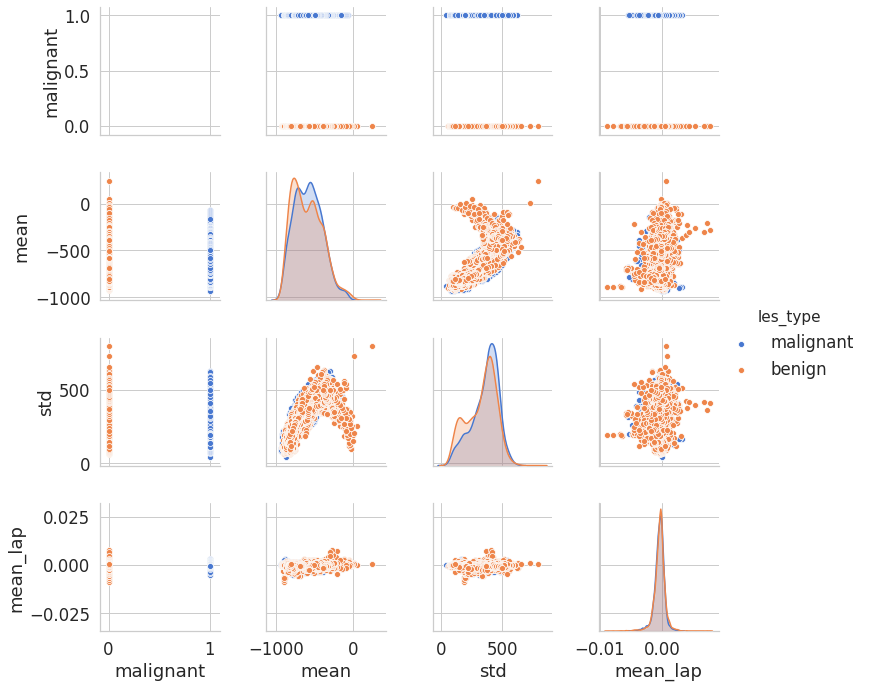

In [64]:
import seaborn as sns
sns.pairplot(all_lesion_df, hue = 'les_type')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


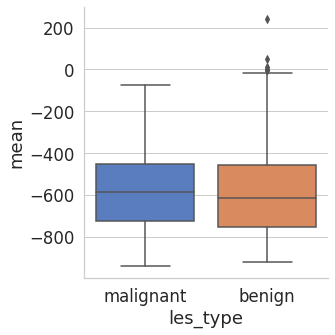

In [66]:
sns.factorplot(x = 'les_type', y = 'mean', kind = 'box', data = all_lesion_df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


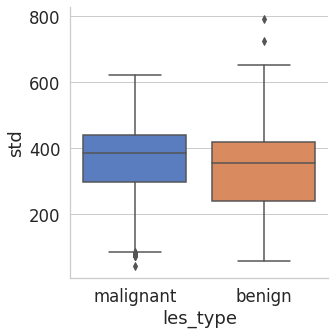

In [67]:
sns.factorplot(x = 'les_type', y = 'std', kind = 'box', data = all_lesion_df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


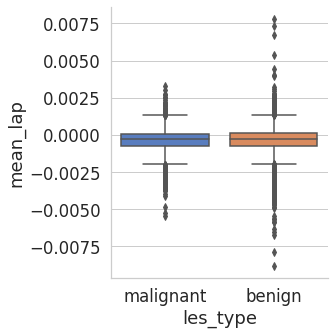

In [68]:
sns.factorplot(x = 'les_type', y = 'mean_lap', kind = 'box', data = all_lesion_df)

In [0]:
data.describe()

,id,Autocorr,Contrast,Correlation_Matlab,Cluster Prominence,Cluster Shade,Dissimilarity,Energy,Entropy,Homogeneity_Matlab,Maximum probability,Sum of sqaures,Sum average,Sum variance,Sum entropy,Difference variance,Difference entropy,Information measure of correlation1,Information measure of correlation2,Inverse difference normalized,Inverse difference moment normalized,malignancy
count,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000,6486.000000
mean,3316.818841,9.512320,2.055022,0.761020,1852.569346,139.519118,0.293823,0.736334,0.502226,0.963304,0.829665,10.477394,4.122763,35.592334,0.473817,2.054780,0.156468,-0.558115,0.531419,0.980429,0.981812,0.379587
std,1914.931546,7.423063,2.024177,0.172692,968.115989,81.476180,0.289364,0.178666,0.297849,0.036147,0.143325,7.932156,1.775457,26.859858,0.276205,2.024369,0.110674,0.186851,0.206035,0.019279,0.017912,0.485322
min,0.000000,0.522569,0.012153,-0.002079,1.188611,-240.686852,0.001736,0.181687,0.004270,0.693142,0.376488,0.968994,2.003472,0.179670,0.004270,0.012153,-0.656141,-0.927420,0.000000,0.836343,0.847929,0.000000
25%,1640.250000,3.073785,0.704861,0.685358,1024.794584,69.889902,0.100694,0.583033,0.241952,0.952474,0.734127,3.584880,2.573351,12.193393,0.230468,0.704861,0.075296,-0.699429,0.394122,0.974653,0.976447,0.000000
50%,3332.500000,7.908854,1.470486,0.813653,2198.386494,157.158305,0.210069,0.740056,0.520675,0.973741,0.853175,8.863363,3.753472,30.138467,0.495439,1.470486,0.134777,-0.594981,0.579987,0.985995,0.986987,0.000000
75%,4980.750000,14.200955,2.661458,0.882444,2659.989201,211.284651,0.380208,0.903535,0.740765,0.987413,0.949839,15.761203,5.298177,52.964321,0.707017,2.661458,0.211031,-0.439669,0.696631,0.993287,0.993762,1.000000
max,6606.000000,48.234375,17.184028,0.980824,3126.590319,257.077522,2.454861,0.999008,1.323222,0.999783,3.553738,49.035889,12.703125,178.118602,1.092179,17.184028,0.647875,0.449091,0.995023,0.999884,0.999892,1.000000


In [0]:
data.columns = data.columns.str.replace(' ', '')

In [0]:
data.columns = data.columns.str.lstrip()

In [0]:
data.columns = data.columns.str.rstrip()

In [0]:
data.columns = data.columns.str.replace(' ', '_')

In [0]:
data.columns

Index(['id', 'Autocorr', 'Contrast', 'Correlation_Matlab', 'ClusterProminence',
       'ClusterShade', 'Dissimilarity', 'Energy', 'Entropy',
       'Homogeneity_Matlab', 'Maximumprobability', 'Sumofsqaures',
       'Sumaverage', 'Sumvariance', 'Sumentropy', 'Differencevariance',
       'Differenceentropy', 'Informationmeasureofcorrelation1',
       'Informationmeasureofcorrelation2', 'Inversedifferencenormalized',
       'Inversedifferencemomentnormalized', 'malignancy'],
      dtype='object')

In [0]:
#removing id column
data.drop(data.columns[0], axis=1, inplace=True)
data.head()

,Autocorr,Contrast,Correlation_Matlab,ClusterProminence,ClusterShade,Dissimilarity,Energy,Entropy,Homogeneity_Matlab,Maximumprobability,Sumofsqaures,Sumaverage,Sumvariance,Sumentropy,Differencevariance,Differenceentropy,Informationmeasureofcorrelation1,Informationmeasureofcorrelation2,Inversedifferencenormalized,Inversedifferencemomentnormalized,malignancy
0,7.35,0.936000,0.901,2420.0,192.0,0.134,0.788,0.428,0.983,0.882,7.79,3.52,27.6,0.415,0.936,0.0945,-0.750,0.635,0.991,0.992,1
1,6.19,1.348958,0.837,2090.0,166.0,0.193,0.804,0.420,0.976,0.893,6.84,3.30,23.6,0.401,1.350,0.1260,-0.642,0.573,0.987,0.988,1
2,6.88,1.260000,0.861,2280.0,181.0,0.181,0.789,0.439,0.977,0.884,7.51,3.45,26.1,0.421,1.260,0.1200,-0.677,0.603,0.988,0.989,1
3,8.23,1.520000,0.860,2520.0,203.0,0.217,0.748,0.505,0.973,0.858,9.08,3.78,31.0,0.484,1.520,0.1380,-0.664,0.633,0.986,0.987,1
4,13.40,1.790000,0.891,2940.0,242.0,0.255,0.631,0.665,0.968,0.770,14.30,4.96,49.6,0.639,1.790,0.1570,-0.709,0.721,0.983,0.984,1


In [0]:
numeric_data = data.select_dtypes(include=[np.number])

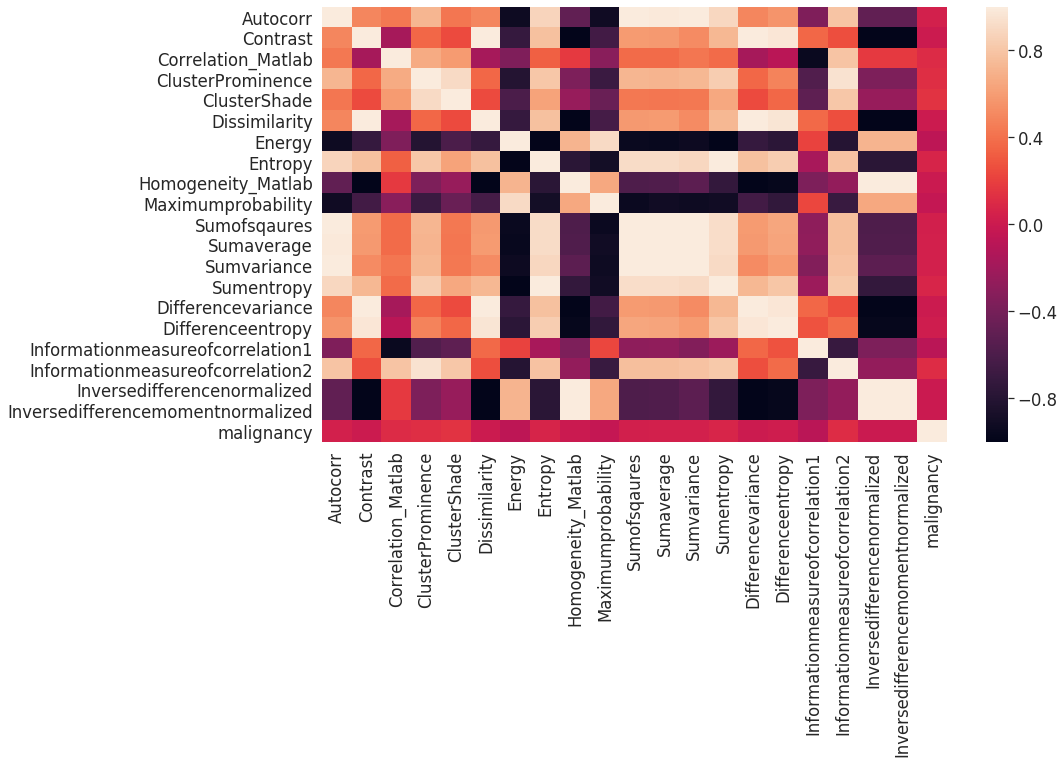

In [70]:
corr = numeric_data.corr()
sns.heatmap(corr)

In [71]:
print (corr['malignancy'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr['malignancy'].sort_values(ascending=False)[-5:]) #last 5 values`

malignancy                          1.000000
ClusterShade                        0.141518
ClusterProminence                   0.119676
Informationmeasureofcorrelation2    0.115360
Correlation_Matlab                  0.101745
Sumentropy                          0.071297
Entropy                             0.066871
Sumvariance                         0.041486
Autocorr                            0.041374
Sumaverage                          0.040514
Sumofsqaures                        0.038124
Differenceentropy                   0.019107
Dissimilarity                       0.001544
Contrast                            0.000448
Differencevariance                  0.000296
Name: malignancy, dtype: float64 

----------------------
Homogeneity_Matlab                  -0.000405
Inversedifferencemomentnormalized   -0.000578
Maximumprobability                  -0.033285
Energy                              -0.064302
Informationmeasureofcorrelation1    -0.085838
Name: malignancy, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


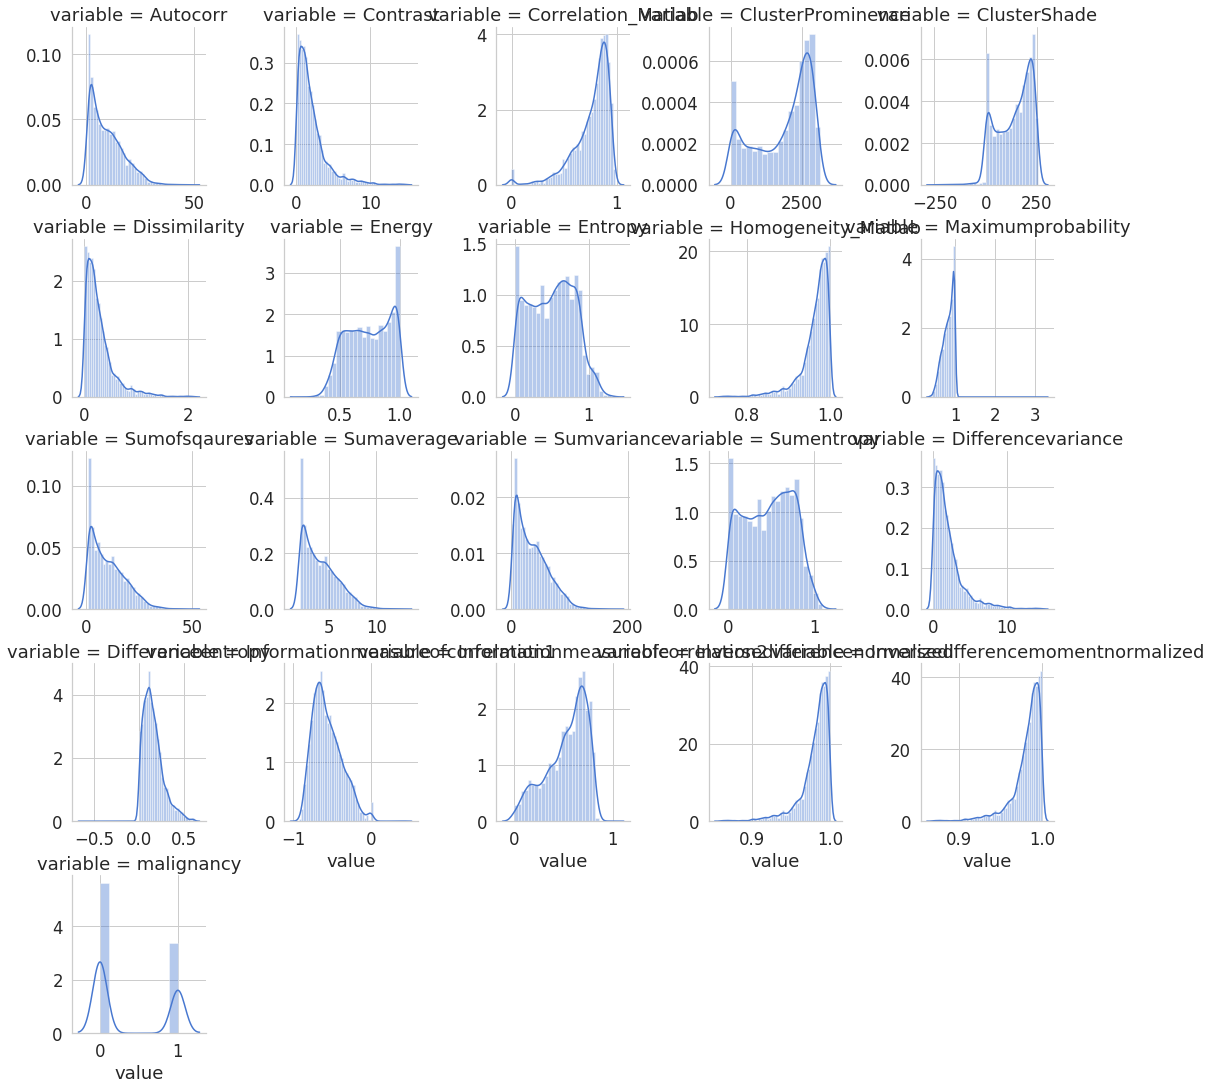

In [87]:
num = [f for f in data.columns]
nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=5, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

In [0]:
X = data.loc[:,data.columns!='malignancy']
y = data.iloc[:,-1]

In [0]:
feature_columns = []

for header in ['Autocorr', 'Contrast', 'Correlation_Matlab', 'ClusterProminence',
       'ClusterShade', 'Dissimilarity', 'Energy', 'Entropy',
       'Homogeneity_Matlab', 'Maximumprobability', 'Sumofsqaures',
       'Sumaverage', 'Sumvariance', 'Sumentropy', 'Differencevariance',
       'Differenceentropy', 'Informationmeasureofcorrelation1',
       'Informationmeasureofcorrelation2', 'Inversedifferencenormalized',
       'Inversedifferencemomentnormalized']:
  feature_columns.append(tf.feature_column.numeric_column(header))
  

print(feature_columns)

[NumericColumn(key='Autocorr', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Contrast', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Correlation_Matlab', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='ClusterProminence', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='ClusterShade', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Dissimilarity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Energy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Entropy', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Homogeneity_Matlab', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Maximumprobability', shape=(1,), def

In [0]:
def create_dataset(dataframe, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('malignancy')
  return tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) \
          .shuffle(buffer_size=len(dataframe)) \
          .batch(batch_size)

In [0]:
train,test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
train_ds = create_dataset(train)
test_ds = create_dataset(test)

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns=feature_columns),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=100, use_multiprocessing=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/100
163/163 [==============================] - 2s 15ms/step - loss: 11.5975 - accuracy: 0.5299 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
163/163 [==============================] - 1s 5ms/step - loss: 4.0297 - accuracy: 0.5335 - val_loss: 4.2096 - val_accuracy: 0.6063
Epoch 3/100
163/163 [==============================] - 1s 5ms/step - loss: 3.3590 - accuracy: 0.5395 - val_loss: 5.6964 - val_accuracy: 0.6063
Epoch 4/100
163/163 [==============================] - 1s 5ms/step - 

In [0]:
model.evaluate(test_ds)

41/41 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.6071


[0.6664296941059392, 0.60708785]

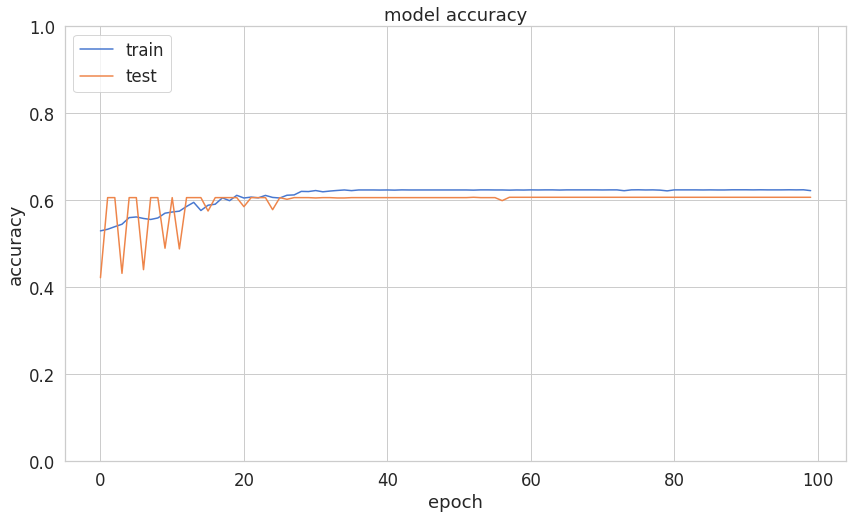

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'test'], loc='upper left');

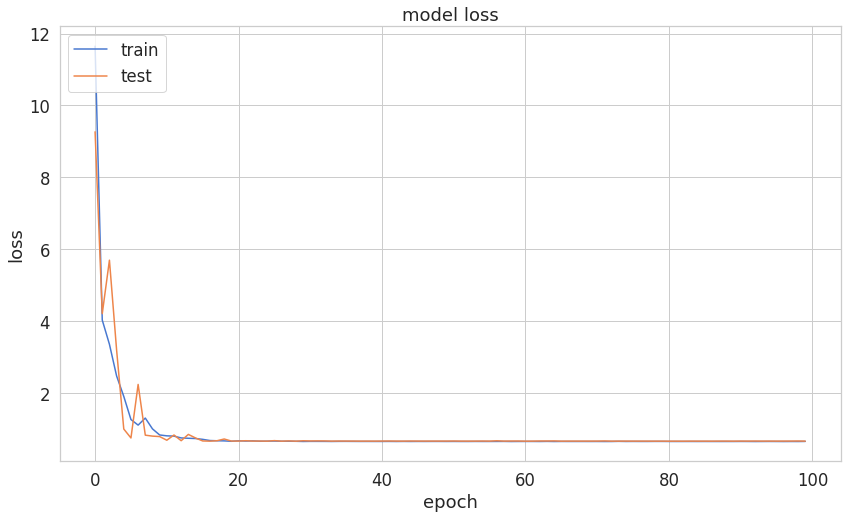

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
predictions = model.predict(test_ds)

In [0]:
bin_predictions = tf.round(predictions).numpy().flatten()
print(bin_predictions)

[0. 0. 0. ... 0. 0. 0.]


In [0]:
print(classification_report(y_test.values, bin_predictions))

NameError: ignored

In [0]:
cnf_matrix = confusion_matrix(y_test, bin_predictions)
cnf_matrix

NameError: ignored

NameError: ignored

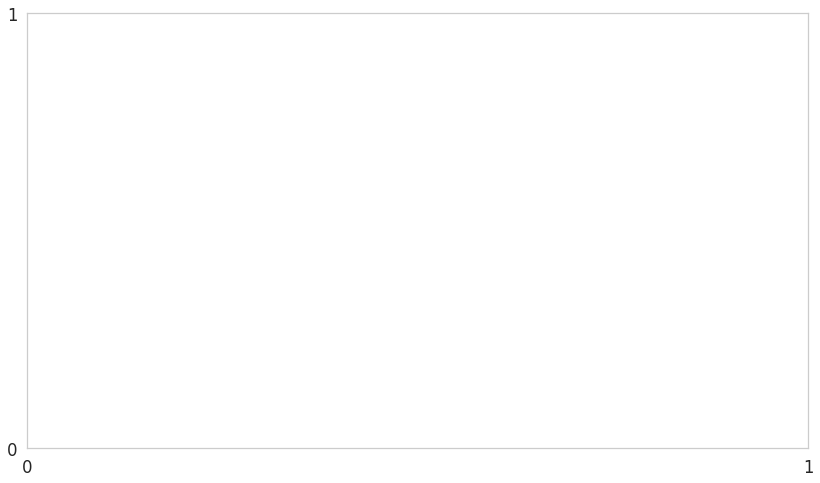

In [0]:
class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)

sns.heatmap(pd.DataFrame(cnf_matrix),annot=True,cmap="Blues",fmt="d",cbar=False)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label');